In [246]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import diagnostic_plots

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [247]:
#read stats data
stats17to18_df = pd.read_pickle('NBAplayersStats.pkl')
stats17to18_df.head()

,name,GP,GS,MIN,FGM-A,FG%,3PM-A,3P%,FTM-A,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
0,Stephen Curry,51,51,32.0,8.4-16.9,.495,4.2-9.8,.423,5.5-5.9,.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4
1,Blake Griffin,33,33,34.5,7.7-17.5,.441,1.9-5.7,.342,5.2-6.6,.785,1.4,6.6,7.9,5.4,0.3,0.9,2.4,3.0,22.6
2,Paul Millsap,69,67,34.0,6.2-14.1,.442,1.1-3.5,.311,4.5-5.9,.768,1.6,6.1,7.7,3.7,0.9,1.3,2.7,2.3,18.1
3,Kyle Lowry,78,78,32.2,5.2-12.1,.427,3.1-7.6,.399,2.9-3.3,.854,0.9,4.7,5.6,6.9,0.2,1.1,2.5,2.3,16.2
4,Gordon Hayward,73,73,34.5,7.5-15.8,.471,2.0-5.1,.398,5.0-5.9,.844,0.7,4.7,5.4,3.5,0.3,1.0,1.6,1.9,21.9


In [248]:
salary18to19_df = pd.read_pickle('salaries18to19.pkl')
salary18to19_df.head()

,name,position,team,salary
0,Stephen Curry,PG,Golden State Warriors,"$37,457,154"
1,Russell Westbrook,PG,Oklahoma City Thunder,"$35,654,150"
2,LeBron James,SF,Los Angeles Lakers,"$35,654,150"
3,Chris Paul,PG,Houston Rockets,"$35,650,150"
4,James Harden,PG,Houston Rockets,"$35,650,150"


In [249]:
salary18to19_df.shape

(395, 4)

In [250]:
stats17to18_df.shape

(465, 19)

In [251]:
df = salary18to19_df.merge(stats17to18_df, on='name', how='inner')
df.head()

,name,position,team,salary,GP,GS,MIN,FGM-A,FG%,3PM-A,3P%,FTM-A,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
0,Stephen Curry,PG,Golden State Warriors,"$37,457,154",51,51,32.0,8.4-16.9,.495,4.2-9.8,.423,5.5-5.9,.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4
1,Russell Westbrook,PG,Oklahoma City Thunder,"$35,654,150",81,81,34.6,10.2-24.0,.425,2.5-7.2,.343,8.8-10.4,.845,1.7,9.0,10.7,10.4,0.4,1.6,2.3,5.4,31.6
2,Chris Paul,PG,Houston Rockets,"$35,650,150",58,58,31.8,6.3-13.8,.460,2.5-6.5,.380,3.5-3.8,.919,0.6,4.8,5.4,7.9,0.2,1.7,2.4,2.2,18.6
3,James Harden,PG,Houston Rockets,"$35,650,150",72,72,35.4,9.0-20.1,.449,3.7-10.0,.367,8.7-10.1,.858,0.6,4.8,5.4,8.8,0.7,1.8,2.3,4.4,30.4
4,Langston Galloway,SG,Detroit Pistons,"$32,088,932",58,2,14.9,2.2-5.9,.371,1.3-3.8,.344,0.6-0.7,.805,0.2,1.4,1.6,1.0,0.1,0.6,0.7,0.3,6.2


In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 288
Data columns (total 22 columns):
name        289 non-null object
position    289 non-null object
team        289 non-null object
salary      289 non-null object
GP          288 non-null object
GS          288 non-null object
MIN         288 non-null object
FGM-A       288 non-null object
FG%         288 non-null object
3PM-A       288 non-null object
3P%         288 non-null object
FTM-A       288 non-null object
FT%         288 non-null object
OR          288 non-null object
DR          288 non-null object
REB         288 non-null object
AST         288 non-null object
BLK         288 non-null object
STL         288 non-null object
PF          288 non-null object
TO          288 non-null object
PTS         288 non-null object
dtypes: object(22)
memory usage: 51.9+ KB


In [253]:
df.columns

Index(['name', 'position', 'team', 'salary', 'GP', 'GS', 'MIN', 'FGM-A', 'FG%',
       '3PM-A', '3P%', 'FTM-A', 'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL',
       'PF', 'TO', 'PTS'],
      dtype='object')

In [254]:
clean_df = df.copy()

In [255]:
#take out 'salary' $ sign 
clean_df['salary'] = ([salary.replace('$', '').replace(',', '') 
                       if '$' in str(salary) else np.nan 
                       for salary in clean_df['salary']])

In [256]:
clean_df.head()

,name,position,team,salary,GP,GS,MIN,FGM-A,FG%,3PM-A,3P%,FTM-A,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
0,Stephen Curry,PG,Golden State Warriors,37457154,51,51,32.0,8.4-16.9,.495,4.2-9.8,.423,5.5-5.9,.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4
1,Russell Westbrook,PG,Oklahoma City Thunder,35654150,81,81,34.6,10.2-24.0,.425,2.5-7.2,.343,8.8-10.4,.845,1.7,9.0,10.7,10.4,0.4,1.6,2.3,5.4,31.6
2,Chris Paul,PG,Houston Rockets,35650150,58,58,31.8,6.3-13.8,.460,2.5-6.5,.380,3.5-3.8,.919,0.6,4.8,5.4,7.9,0.2,1.7,2.4,2.2,18.6
3,James Harden,PG,Houston Rockets,35650150,72,72,35.4,9.0-20.1,.449,3.7-10.0,.367,8.7-10.1,.858,0.6,4.8,5.4,8.8,0.7,1.8,2.3,4.4,30.4
4,Langston Galloway,SG,Detroit Pistons,32088932,58,2,14.9,2.2-5.9,.371,1.3-3.8,.344,0.6-0.7,.805,0.2,1.4,1.6,1.0,0.1,0.6,0.7,0.3,6.2


In [257]:
#make 'sarlary' to numeric
clean_df['salary'] = clean_df['salary'].apply(pd.to_numeric)

#convert ''GP', 'GS' to numeric
clean_df['GP'] = clean_df['GP'].apply(pd.to_numeric)
clean_df['GS'] = clean_df['GS'].apply(pd.to_numeric)

In [258]:
#convert 'position' to categorical
clean_df["position"] = clean_df["position"].astype('category')

#convert 'MIN', 'FG%', '3P%', 'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS' into numeric
to_num = ['MIN', 'FG%', '3P%', 'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']
clean_df[to_num] = clean_df[to_num].apply(pd.to_numeric)

#renaming the 'FG%', '3P%', 'FT%' column
clean_df = clean_df.rename(columns={'FG%': 'FG_precentage', '3P%': 'ThreePoint_precentage', 'FT%': 'FT_precentage'})

#drop NAs
clean_df = clean_df.dropna()

#now have 438 rows
clean_df.info()

#drop these 3 columns because we already got those in precentages
clean_df = clean_df.drop(['name', 'team', 'FGM-A', '3PM-A', 'FTM-A'], axis=1)

clean_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 288
Data columns (total 22 columns):
name                     288 non-null object
position                 288 non-null category
team                     288 non-null object
salary                   288 non-null int64
GP                       288 non-null float64
GS                       288 non-null float64
MIN                      288 non-null float64
FGM-A                    288 non-null object
FG_precentage            288 non-null float64
3PM-A                    288 non-null object
ThreePoint_precentage    288 non-null float64
FTM-A                    288 non-null object
FT_precentage            288 non-null float64
OR                       288 non-null float64
DR                       288 non-null float64
REB                      288 non-null float64
AST                      288 non-null float64
BLK                      288 non-null float64
STL                      288 non-null float64
PF                       28

,position,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
0,PG,37457154,51.0,51.0,32.0,0.495,0.423,0.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4
1,PG,35654150,81.0,81.0,34.6,0.425,0.343,0.845,1.7,9.0,10.7,10.4,0.4,1.6,2.3,5.4,31.6
2,PG,35650150,58.0,58.0,31.8,0.460,0.380,0.919,0.6,4.8,5.4,7.9,0.2,1.7,2.4,2.2,18.6
3,PG,35650150,72.0,72.0,35.4,0.449,0.367,0.858,0.6,4.8,5.4,8.8,0.7,1.8,2.3,4.4,30.4
4,SG,32088932,58.0,2.0,14.9,0.371,0.344,0.805,0.2,1.4,1.6,1.0,0.1,0.6,0.7,0.3,6.2


In [259]:
clean_df.corr().sort_values(by='salary', ascending=False )

,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
salary,1.000000,0.194956,0.520206,0.595598,0.158559,0.086441,0.187440,0.247932,0.431288,0.399480,0.447534,0.251210,0.451081,0.298505,0.497111,0.649429
PTS,0.649429,0.374944,0.677016,0.852414,0.145296,0.271658,0.417617,0.249851,0.579101,0.510438,0.639518,0.336037,0.609357,0.497482,0.814292,1.000000
MIN,0.595598,0.525541,0.794761,1.000000,0.157248,0.256809,0.360129,0.322440,0.632188,0.572336,0.600132,0.367370,0.699551,0.644439,0.701568,0.852414
GS,0.520206,0.568721,1.000000,0.794761,0.196317,0.107190,0.177290,0.385439,0.577950,0.552881,0.433932,0.379710,0.528560,0.543308,0.532134,0.677016
TO,0.497111,0.204069,0.532134,0.701568,0.059158,0.137347,0.255870,0.209967,0.525507,0.457517,0.799823,0.314702,0.621757,0.522449,1.000000,0.814292
STL,0.451081,0.292128,0.528560,0.699551,0.040485,0.198502,0.188617,0.090011,0.400219,0.326093,0.639423,0.212186,1.000000,0.454514,0.621757,0.609357
AST,0.447534,0.205009,0.433932,0.600132,-0.077524,0.205737,0.252737,-0.088766,0.265943,0.169846,1.000000,0.003184,0.639423,0.272343,0.799823,0.639518
DR,0.431288,0.368293,0.577950,0.632188,0.390756,-0.072697,0.090308,0.734866,1.000000,0.976577,0.265943,0.661526,0.400219,0.629879,0.525507,0.579101
REB,0.399480,0.352055,0.552881,0.572336,0.478851,-0.161244,0.025814,0.863037,0.976577,1.000000,0.169846,0.695703,0.326093,0.632938,0.457517,0.510438
PF,0.298505,0.417750,0.543308,0.644439,0.278714,-0.015127,0.167830,0.518150,0.629879,0.632938,0.272343,0.555933,0.454514,1.000000,0.522449,0.497482


In [260]:
clean_df.describe()

,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
count,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,1.026020e+07,57.552083,32.722222,23.406250,0.454417,0.302132,0.735962,0.972917,3.357639,4.320833,2.229861,0.473264,0.772917,1.910764,1.367708,10.534722
std,8.490537e+06,23.034077,30.120882,8.261187,0.074615,0.147746,0.154504,0.809673,1.904189,2.554994,1.850815,0.437462,0.435485,0.681146,0.833718,6.197620
min,1.378242e+06,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.988960e+06,41.750000,4.000000,17.175000,0.412750,0.284500,0.684250,0.400000,2.100000,2.500000,0.900000,0.200000,0.500000,1.500000,0.800000,5.900000
50%,7.984768e+06,66.500000,23.000000,24.350000,0.451000,0.347000,0.772500,0.700000,3.000000,3.800000,1.600000,0.300000,0.700000,1.900000,1.200000,9.250000
75%,1.498125e+07,76.000000,63.000000,30.625000,0.493250,0.381000,0.836250,1.325000,4.300000,5.400000,3.000000,0.600000,1.000000,2.325000,1.800000,13.925000
max,3.745715e+07,82.000000,82.000000,37.200000,0.731000,1.000000,1.000000,5.100000,10.700000,14.100000,10.700000,2.500000,2.400000,3.800000,5.400000,31.600000


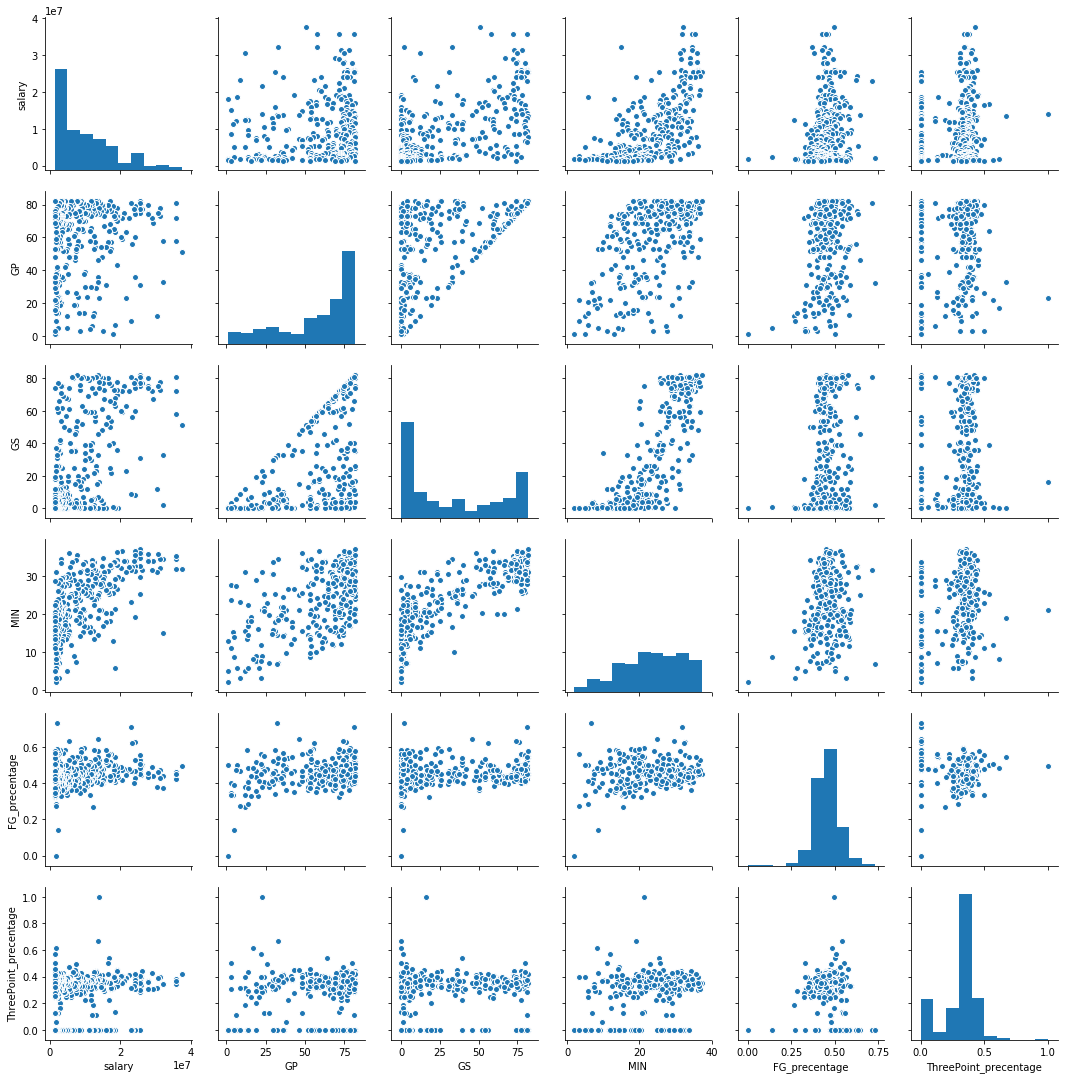

In [261]:
#pairplot
sns.pairplot(clean_df.iloc[:, :7])

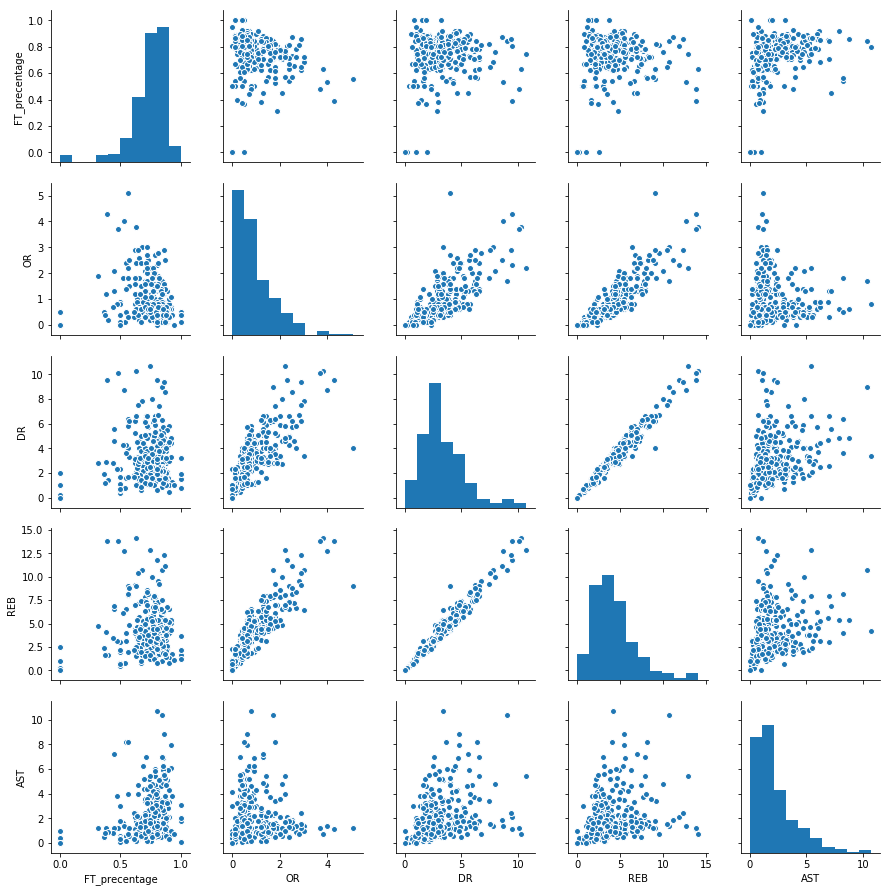

In [262]:
#pairplot
sns.pairplot(clean_df.iloc[:,[0, 7, 8, 9, 10, 11]])

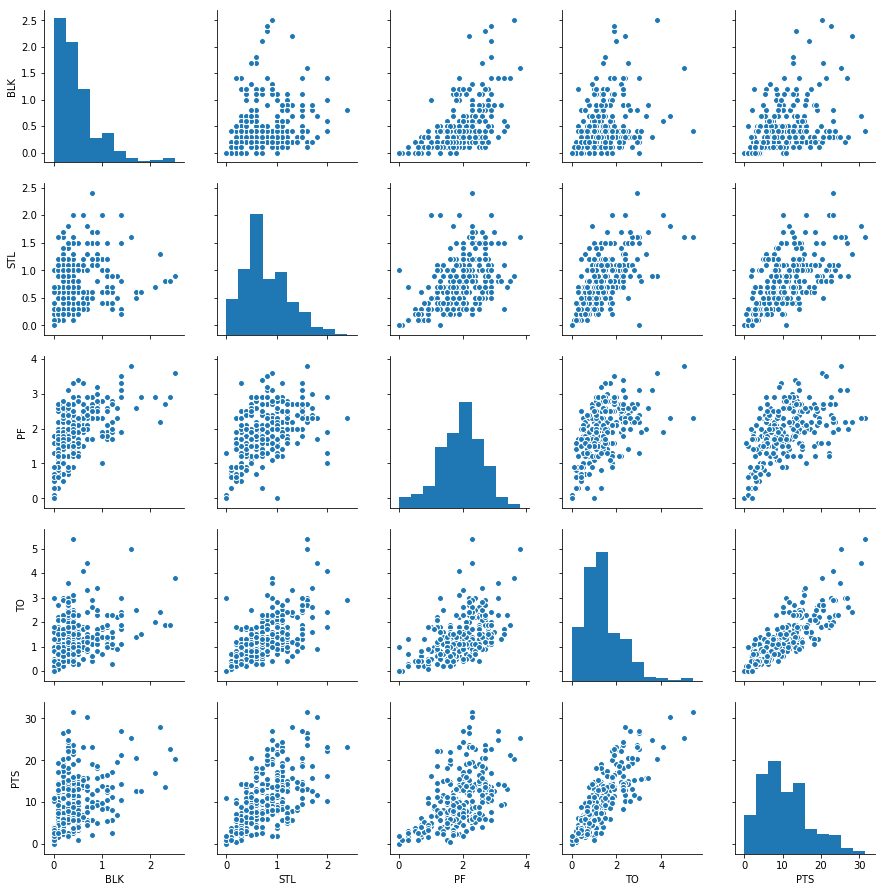

In [263]:
#pairplot
sns.pairplot(clean_df.iloc[:,[0, 12, 13, 14, 15, 16]])

In [264]:
#add a column of log_salary
clean_df['log_salary'] = np.log(clean_df['salary'])

In [265]:
#see corr of log_salary
clean_df.corr().log_salary.sort_values(ascending=False)

log_salary               1.000000
salary                   0.921774
MIN                      0.631375
PTS                      0.594200
GS                       0.522816
TO                       0.467755
STL                      0.461362
DR                       0.428991
REB                      0.404899
AST                      0.401982
PF                       0.374681
BLK                      0.279275
OR                       0.271811
GP                       0.241076
FT_precentage            0.186506
FG_precentage            0.173051
ThreePoint_precentage    0.076754
Name: log_salary, dtype: float64

# Base Model

In [266]:
clean_df.position.unique()

[PG, SG, PF, SF, C, G]
Categories (6, object): [PG, SG, PF, SF, C, G]

In [267]:
#get dummy for 'position' column
#position_C is the base here
clean_df = pd.get_dummies(clean_df, columns=['position'], drop_first=True)

In [268]:
clean_df.head()

,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,log_salary,position_ G,position_ PF,position_ PG,position_ SF,position_ SG
0,37457154,51.0,51.0,32.0,0.495,0.423,0.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4,17.438708,0,0,1,0,0
1,35654150,81.0,81.0,34.6,0.425,0.343,0.845,1.7,9.0,10.7,10.4,0.4,1.6,2.3,5.4,31.6,17.389376,0,0,1,0,0
2,35650150,58.0,58.0,31.8,0.460,0.380,0.919,0.6,4.8,5.4,7.9,0.2,1.7,2.4,2.2,18.6,17.389264,0,0,1,0,0
3,35650150,72.0,72.0,35.4,0.449,0.367,0.858,0.6,4.8,5.4,8.8,0.7,1.8,2.3,4.4,30.4,17.389264,0,0,1,0,0
4,32088932,58.0,2.0,14.9,0.371,0.344,0.805,0.2,1.4,1.6,1.0,0.1,0.6,0.7,0.3,6.2,17.284022,0,0,0,0,1


In [269]:
#renaming the 'position_ F', 'position_ G', 'position_ PF', 'position_ PG', 'position_ SF', 'position_ SG' columns
clean_df = clean_df.rename(columns={'position_ G': 'position_G',
                                    'position_ PF': 'position_PF', 'position_ PG': 'position_PG', 
                                   'position_ SF': 'position_SF', 'position_ SG': 'position_SG'})

In [270]:
pd.set_option('display.max_columns', 50)

In [271]:
clean_df.head()

,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,log_salary,position_G,position_PF,position_PG,position_SF,position_SG
0,37457154,51.0,51.0,32.0,0.495,0.423,0.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4,17.438708,0,0,1,0,0
1,35654150,81.0,81.0,34.6,0.425,0.343,0.845,1.7,9.0,10.7,10.4,0.4,1.6,2.3,5.4,31.6,17.389376,0,0,1,0,0
2,35650150,58.0,58.0,31.8,0.460,0.380,0.919,0.6,4.8,5.4,7.9,0.2,1.7,2.4,2.2,18.6,17.389264,0,0,1,0,0
3,35650150,72.0,72.0,35.4,0.449,0.367,0.858,0.6,4.8,5.4,8.8,0.7,1.8,2.3,4.4,30.4,17.389264,0,0,1,0,0
4,32088932,58.0,2.0,14.9,0.371,0.344,0.805,0.2,1.4,1.6,1.0,0.1,0.6,0.7,0.3,6.2,17.284022,0,0,0,0,1


### splitting train, test set for base mdoel

In [272]:
#split train, test set
X = clean_df.drop(['salary', 'log_salary'], axis=1)
y = clean_df.salary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [273]:
X_train.head()

,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,position_G,position_PF,position_PG,position_SF,position_SG
93,61.0,59.0,33.7,0.424,0.378,0.642,0.4,1.9,2.4,4.0,0.3,1.2,2.5,1.8,15.1,0,0,1,0,0
66,31.0,0.0,17.9,0.586,0.000,0.573,1.5,3.3,4.8,0.6,0.8,1.1,2.9,1.1,5.6,0,0,0,0,0
63,57.0,56.0,31.3,0.502,0.420,0.776,0.8,2.3,3.1,2.9,0.1,1.2,1.6,1.3,14.9,0,0,0,0,1
79,23.0,16.0,21.2,0.497,1.000,0.718,1.7,2.8,4.5,0.6,0.7,0.6,1.7,1.2,9.0,0,1,0,0,0
25,75.0,75.0,36.7,0.529,0.307,0.760,2.1,8.0,10.0,4.8,1.4,1.5,3.1,3.0,26.9,0,1,0,0,0


In [274]:
y_train.head()

93    12650000
66    15944154
63    16517857
79    14000000
25    24157303
Name: salary, dtype: int64

In [275]:
basemodel_train_df = pd.concat([y_train, X_train], axis=1)

In [276]:
basemodel_test_df = pd.concat([y_test, X_test], axis=1)

In [277]:
#run base OLS model
#Y='salary'
#x='position_ F', 'position_ G', 'position_ PF', 'position_ PG', 'position_ SF', 'position_ SG', 'GP', 'GS', 'MIN', 'FG_precentage', 'ThreePoint_precentage', 'FT_precentage', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS'
lsm = smf.ols('salary ~ position_G + position_PF + position_PG + position_SF + position_SG + GP +GS + MIN + FG_precentage + ThreePoint_precentage + FT_precentage + OR + DR + REB + AST + BLK + STL + PF + TO + PTS', data = basemodel_train_df)
basemodelOLS = lsm.fit()
basemodelOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     10.98
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           4.27e-23
Time:                        16:14:43   Log-Likelihood:                -3914.5
No. Observations:                 230   AIC:                             7871.
Df Residuals:                     209   BIC:                             7943.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.136e+06   4.54e+06      1.573      0.117   -1.81e+06    1.61e+07
position_G            -8.549e+06   4.89e+06     -1.749      0.082   -1.82e+07    1.09e+06
position_PF           -3.445e+06   1.57e+06     -2.187      0.030   -6.55e+06    -3.4e+05
position_PG           -6.246e+06   2.28e+06     -2.745      0.007   -1.07e+07   -1.76e+06
position_SF           -2.558e+06   1.88e+06     -1.357      0.176   -6.27e+06    1.16e+06
position_SG           -3.994e+06   2.01e+06     -1.983      0.049   -7.96e+06   -2.25e+04
GP                    -5.201e+04   2.43e+04     -2.140      0.033   -9.99e+04   -4108.442
GS                      3.46e+04   2.56e+04      1.354      0.177   -1.58e+04     8.5e+04
MIN                    1.001e+05   1.51e+05      0.664      0.507   -1.97e+05    3.97e+05
FG_precentage          1.298e+06   8.12e+06      0.160      0.873   -1.47e+07    1.73e+07
ThreePoint_precentage -1.312e+05   3.53e+06     -0.037      0.970    -7.1e+06    6.83e+06
FT_precentage         -1.353e+06   3.35e+06     -0.403      0.687   -7.96e+06    5.26e+06
OR                    -8.129e+06   8.86e+06     -0.917      0.360   -2.56e+07    9.34e+06
DR                    -9.437e+06    8.8e+06     -1.072      0.285   -2.68e+07    7.92e+06
REB                    9.284e+06   8.79e+06      1.056      0.292   -8.05e+06    2.66e+07
AST                    1.415e+06   5.73e+05      2.472      0.014    2.86e+05    2.54e+06
BLK                   -2.965e+05   1.44e+06     -0.206      0.837   -3.13e+06    2.54e+06
STL                    1.014e+06   1.52e+06      0.668      0.505   -1.98e+06    4.01e+06
PF                    -1.872e+06   1.04e+06     -1.801      0.073   -3.92e+06    1.77e+05
TO                    -1.422e+06    1.4e+06     -1.017      0.310   -4.18e+06    1.33e+06
PTS                    7.647e+05   1.85e+05      4.134      0.000       4e+05    1.13e+06
==============================================================================
Omnibus:                       10.954   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.236
Skew:                           0.329   Prob(JB):                     0.000491
Kurtosis:                       4.076   Cond. No.                     2.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

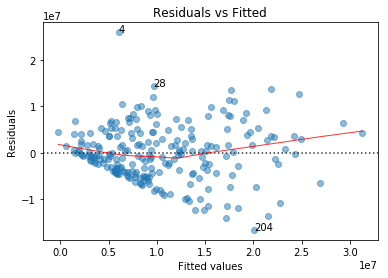

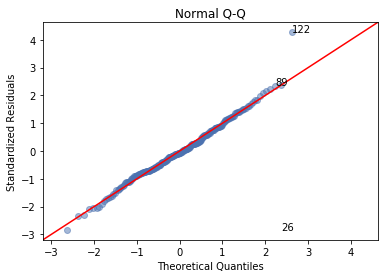

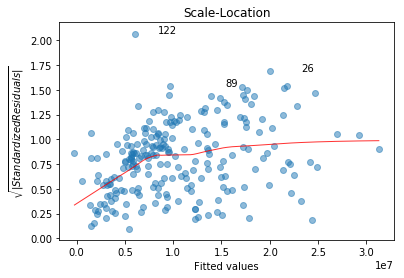

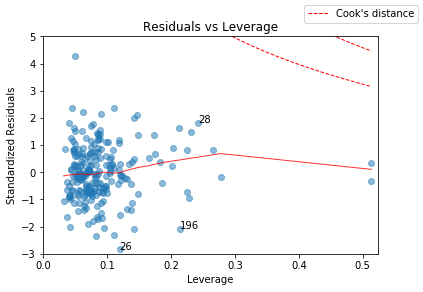

In [278]:
diagnostic_plots.diagnostic_plots(basemodel_train_df.drop('salary', axis=1), basemodel_train_df['salary'], basemodelOLS)

In [279]:
#MSRE using X_train and basemodelOLS
train_set_pred1 = basemodelOLS.predict(X_train)
np.sqrt(np.mean((train_set_pred1 - y_train)**2))

5960978.377668807

In [280]:
#RMSE using X_test and basemodelOLS
test_set_pred1 = basemodelOLS.predict(X_test)

baseRMSE = np.sqrt(np.mean((test_set_pred1 - y_test)**2))
baseRMSE

6456607.968590845

# Model2: should I log transform the target variable (Salary)?

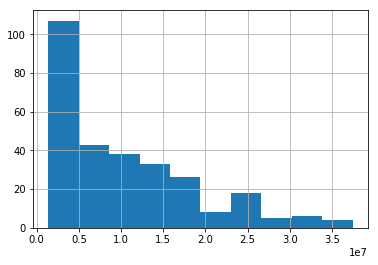

In [281]:
clean_df.salary.hist()

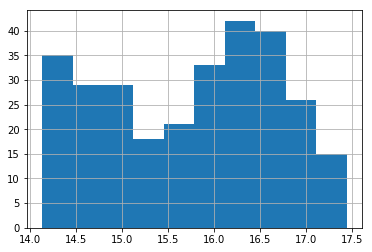

In [282]:
np.log(clean_df.salary).hist()

In [283]:
clean_df['log_salary'] = np.log(clean_df['salary'])
X2 = clean_df.drop(['salary', 'log_salary'], axis=1)
y2 = clean_df['log_salary']

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

In [284]:
log_salary_train_df = pd.concat([y_train, X_train], axis=1)
log_salary_test_df = pd.concat([y_test, X_test], axis=1)

In [285]:
lsm = smf.ols('log_salary ~ position_G + position_PF + position_PG + position_SF + position_SG + GP +GS + MIN + FG_precentage + ThreePoint_precentage + FT_precentage + OR + DR + REB + AST + BLK + STL + PF + TO + PTS', data = log_salary_train_df)
log_salaryOLS = lsm.fit()
log_salaryOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     8.752
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           1.44e-18
Time:                        16:15:07   Log-Likelihood:                -242.82
No. Observations:                 230   AIC:                             527.6
Df Residuals:                     209   BIC:                             599.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.9146      0.529     28.181      0.000      13.871      15.958
position_G               -1.2010      0.570     -2.106      0.036      -2.325      -0.077
position_PF              -0.4364      0.184     -2.375      0.018      -0.799      -0.074
position_PG              -0.7324      0.265     -2.759      0.006      -1.256      -0.209
position_SF              -0.3678      0.220     -1.673      0.096      -0.801       0.066
position_SG              -0.5730      0.235     -2.438      0.016      -1.036      -0.110
GP                       -0.0053      0.003     -1.886      0.061      -0.011       0.000
GS                        0.0015      0.003      0.505      0.614      -0.004       0.007
MIN                       0.0572      0.018      3.253      0.001       0.023       0.092
FG_precentage             0.2496      0.947      0.264      0.792      -1.617       2.116
ThreePoint_precentage     0.0560      0.412      0.136      0.892      -0.757       0.869
FT_precentage            -0.1259      0.391     -0.322      0.748      -0.897       0.645
OR                       -0.3408      1.034     -0.330      0.742      -2.379       1.697
DR                       -0.5638      1.027     -0.549      0.584      -2.589       1.461
REB                       0.4904      1.026      0.478      0.633      -1.532       2.513
AST                       0.1110      0.067      1.662      0.098      -0.021       0.243
BLK                      -0.0142      0.168     -0.084      0.933      -0.345       0.317
STL                       0.1053      0.177      0.595      0.553      -0.244       0.455
PF                       -0.1406      0.121     -1.159      0.248      -0.380       0.098
TO                       -0.0848      0.163     -0.520      0.604      -0.406       0.237
PTS                       0.0343      0.022      1.588      0.114      -0.008       0.077
==============================================================================
Omnibus:                        3.166   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.205   Jarque-Bera (JB):                3.217
Skew:                          -0.261   Prob(JB):                        0.200
Kurtosis:                       2.749   Cond. No.                     2.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KeyError: 157

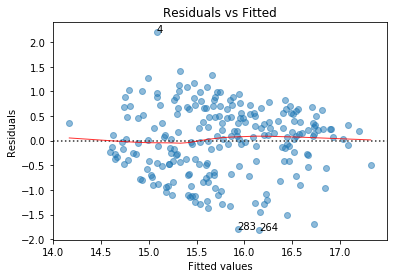

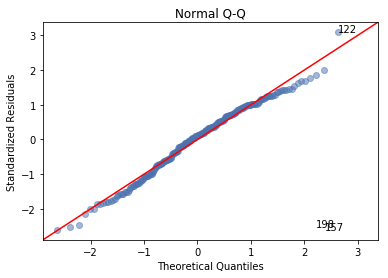

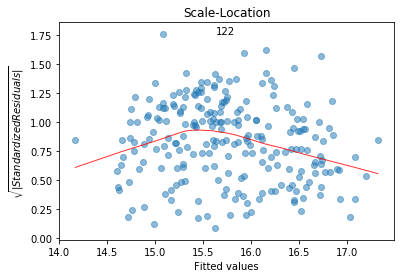

In [286]:
diagnostic_plots.diagnostic_plots(log_salary_train_df.drop('log_salary', axis=1), log_salary_train_df['log_salary'], log_salaryOLS)

In [287]:
#RMSE using X_train and log_salaryOLS
train_set_pred2 = log_salaryOLS.predict(X_train)
np.sqrt(np.mean((train_set_pred2 - y_train)**2))

0.6954417829083206

In [288]:
#RMSE using X_test and log_salaryOLS
test_set_pred2 = log_salaryOLS.predict(X_test)

log_salaryRMSE = np.sqrt(np.mean((test_set_pred2 - y_test)**2))
log_salaryRMSE

0.6506735551189619

In [289]:
y_predict_dollar = np.exp(test_set_pred2)

In [290]:
np.sqrt(np.mean((y_predict_dollar - np.exp(y_test))**2))

6267842.668429982

In [291]:
clean_df.describe()

,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,log_salary,position_G,position_PF,position_PG,position_SF,position_SG
count,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,1.026020e+07,57.552083,32.722222,23.406250,0.454417,0.302132,0.735962,0.972917,3.357639,4.320833,2.229861,0.473264,0.772917,1.910764,1.367708,10.534722,15.755906,0.010417,0.194444,0.197917,0.201389,0.201389
std,8.490537e+06,23.034077,30.120882,8.261187,0.074615,0.147746,0.154504,0.809673,1.904189,2.554994,1.850815,0.437462,0.435485,0.681146,0.833718,6.197620,0.935361,0.101706,0.396461,0.399123,0.401736,0.401736
min,1.378242e+06,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.136319,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.988960e+06,41.750000,4.000000,17.175000,0.412750,0.284500,0.684250,0.400000,2.100000,2.500000,0.900000,0.200000,0.500000,1.500000,0.800000,5.900000,14.910415,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.984768e+06,66.500000,23.000000,24.350000,0.451000,0.347000,0.772500,0.700000,3.000000,3.800000,1.600000,0.300000,0.700000,1.900000,1.200000,9.250000,15.893045,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.498125e+07,76.000000,63.000000,30.625000,0.493250,0.381000,0.836250,1.325000,4.300000,5.400000,3.000000,0.600000,1.000000,2.325000,1.800000,13.925000,16.522310,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.745715e+07,82.000000,82.000000,37.200000,0.731000,1.000000,1.000000,5.100000,10.700000,14.100000,10.700000,2.500000,2.400000,3.800000,5.400000,31.600000,17.438708,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0,0.5,'Residuals')

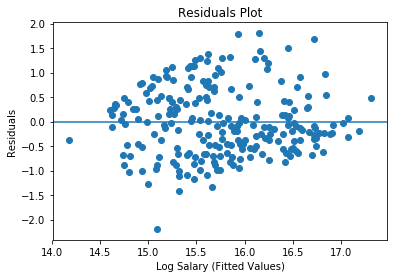

In [292]:
plt.scatter(train_set_pred2, train_set_pred2-(y_train))
plt.gca().axhline(0)


plt.title('Residuals Plot')
plt.xlabel('Log Salary (Fitted Values)')
plt.ylabel('Residuals')

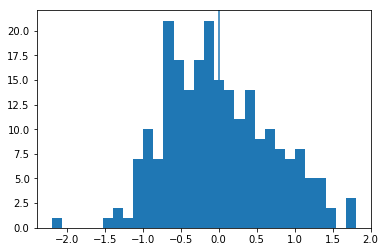

In [293]:
plt.hist(train_set_pred2-(y_train), bins=30)
plt.gca().axvline(0);

# Model3: Drop DR and OR

In [294]:
#dropped OR, DR
lsm = smf.ols('log_salary ~ position_G + position_PF + position_PG + position_SF + position_SG + GP +GS + MIN + FG_precentage + ThreePoint_precentage + FT_precentage + REB + AST + BLK + STL + PF + TO + PTS', data = log_salary_train_df)
droppedDROROLS = lsm.fit()
droppedDROROLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     9.664
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.86e-19
Time:                        16:15:27   Log-Likelihood:                -243.64
No. Observations:                 230   AIC:                             525.3
Df Residuals:                     211   BIC:                             590.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.8282      0.523     28.359      0.000      13.797      15.859
position_G               -1.1591      0.565     -2.050      0.042      -2.274      -0.044
position_PF              -0.4492      0.183     -2.452      0.015      -0.810      -0.088
position_PG              -0.7032      0.264     -2.664      0.008      -1.224      -0.183
position_SF              -0.4200      0.215     -1.951      0.052      -0.844       0.004
position_SG              -0.5983      0.233     -2.563      0.011      -1.058      -0.138
GP                       -0.0058      0.003     -2.051      0.041      -0.011      -0.000
GS                        0.0019      0.003      0.636      0.525      -0.004       0.008
MIN                       0.0575      0.018      3.283      0.001       0.023       0.092
FG_precentage             0.6387      0.880      0.725      0.469      -1.097       2.374
ThreePoint_precentage     0.0106      0.408      0.026      0.979      -0.794       0.815
FT_precentage            -0.1929      0.387     -0.498      0.619      -0.956       0.570
REB                      -0.0182      0.039     -0.472      0.638      -0.094       0.058
AST                       0.0870      0.063      1.377      0.170      -0.038       0.212
BLK                      -0.0323      0.167     -0.194      0.847      -0.361       0.297
STL                       0.0917      0.177      0.519      0.604      -0.256       0.440
PF                       -0.1209      0.120     -1.008      0.314      -0.357       0.115
TO                       -0.0868      0.162     -0.536      0.593      -0.406       0.233
PTS                       0.0339      0.021      1.578      0.116      -0.008       0.076
==============================================================================
Omnibus:                        2.897   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.923
Skew:                          -0.240   Prob(JB):                        0.232
Kurtosis:                       2.726   Cond. No.                     1.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KeyError: 157

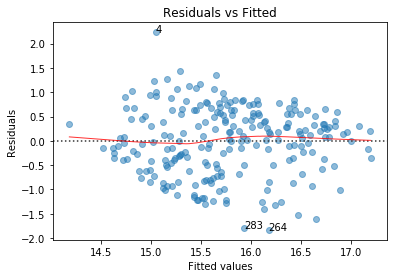

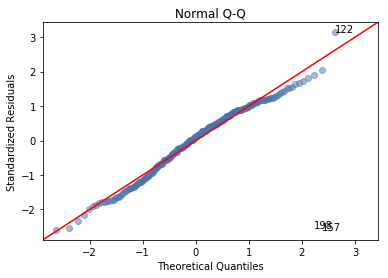

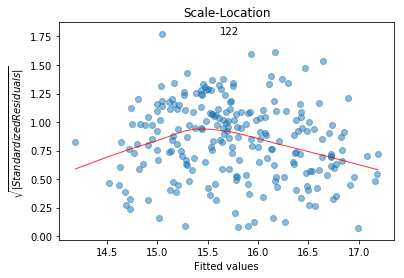

In [295]:
diagnostic_plots.diagnostic_plots(log_salary_train_df.drop(['log_salary', 'OR', 'DR'], axis=1), log_salary_train_df['log_salary'], droppedDROROLS)

In [296]:
X_train.head()

,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,position_G,position_PF,position_PG,position_SF,position_SG
93,61.0,59.0,33.7,0.424,0.378,0.642,0.4,1.9,2.4,4.0,0.3,1.2,2.5,1.8,15.1,0,0,1,0,0
66,31.0,0.0,17.9,0.586,0.000,0.573,1.5,3.3,4.8,0.6,0.8,1.1,2.9,1.1,5.6,0,0,0,0,0
63,57.0,56.0,31.3,0.502,0.420,0.776,0.8,2.3,3.1,2.9,0.1,1.2,1.6,1.3,14.9,0,0,0,0,1
79,23.0,16.0,21.2,0.497,1.000,0.718,1.7,2.8,4.5,0.6,0.7,0.6,1.7,1.2,9.0,0,1,0,0,0
25,75.0,75.0,36.7,0.529,0.307,0.760,2.1,8.0,10.0,4.8,1.4,1.5,3.1,3.0,26.9,0,1,0,0,0


In [297]:
#MSRE using X_train and droppedDROROLS
train_set_pred3 = droppedDROROLS.predict(X_train)
np.sqrt(np.mean((train_set_pred3 - y_train)**2))

0.6979242825338133

In [298]:
#MSRE using X_test and dropped DROROLS
test_set_pred3 = droppedDROROLS.predict(X_test)

droppedORDRModelRMSE = np.sqrt(np.mean((test_set_pred3 - (y_test))**2))
droppedORDRModelRMSE

0.6453913022773288

Text(0,0.5,'Residuals')

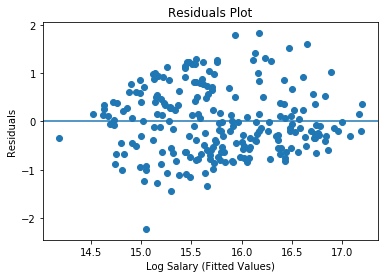

In [299]:
plt.scatter(train_set_pred3, train_set_pred3-(y_train))
plt.gca().axhline(0)


plt.title('Residuals Plot')
plt.xlabel('Log Salary (Fitted Values)')
plt.ylabel('Residuals')

In [300]:
y_predict_dollar3 = np.exp(test_set_pred3)

In [301]:
np.sqrt(np.mean((y_predict_dollar3 - np.exp(y_test))**2))

6088140.51428578

# model4 log REB

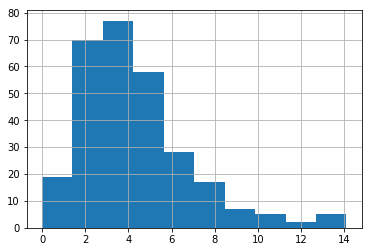

In [302]:
X2.REB.hist()

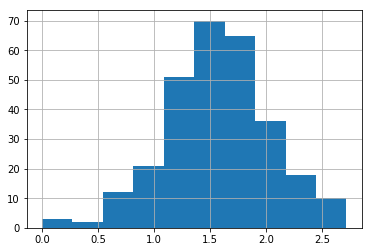

In [303]:
np.log(X2.REB+1).hist()

In [304]:
clean_df.head()

,salary,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,log_salary,position_G,position_PF,position_PG,position_SF,position_SG
0,37457154,51.0,51.0,32.0,0.495,0.423,0.921,0.7,4.4,5.1,6.1,0.2,1.6,2.2,3.0,26.4,17.438708,0,0,1,0,0
1,35654150,81.0,81.0,34.6,0.425,0.343,0.845,1.7,9.0,10.7,10.4,0.4,1.6,2.3,5.4,31.6,17.389376,0,0,1,0,0
2,35650150,58.0,58.0,31.8,0.460,0.380,0.919,0.6,4.8,5.4,7.9,0.2,1.7,2.4,2.2,18.6,17.389264,0,0,1,0,0
3,35650150,72.0,72.0,35.4,0.449,0.367,0.858,0.6,4.8,5.4,8.8,0.7,1.8,2.3,4.4,30.4,17.389264,0,0,1,0,0
4,32088932,58.0,2.0,14.9,0.371,0.344,0.805,0.2,1.4,1.6,1.0,0.1,0.6,0.7,0.3,6.2,17.284022,0,0,0,0,1


In [305]:
clean_df['log_REB'] = np.log(clean_df['REB']+1)
X3 = clean_df.drop(['salary', 'log_salary', 'REB'], axis=1)
y3 = clean_df['log_salary']

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.20, random_state=42)

In [306]:
log_REB_train_df = pd.concat([y_train, X_train], axis=1)
log_REB_test_df = pd.concat([y_test, X_test], axis=1)

In [307]:
#log REB
lsm = smf.ols('log_salary ~ position_G + position_PF + position_PG + position_SF + position_SG + GP +GS + MIN + FG_precentage + ThreePoint_precentage + FT_precentage + log_REB + AST + BLK + STL + PF + TO + PTS', data = log_REB_train_df)
logREBOLS = lsm.fit()
logREBOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     9.763
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           1.84e-19
Time:                        16:15:51   Log-Likelihood:                -243.11
No. Observations:                 230   AIC:                             524.2
Df Residuals:                     211   BIC:                             589.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.8940      0.525     28.370      0.000      13.859      15.929
position_G               -1.2550      0.572     -2.194      0.029      -2.383      -0.127
position_PF              -0.4625      0.183     -2.529      0.012      -0.823      -0.102
position_PG              -0.7793      0.270     -2.888      0.004      -1.311      -0.247
position_SF              -0.4662      0.216     -2.155      0.032      -0.893      -0.040
position_SG              -0.6714      0.238     -2.817      0.005      -1.141      -0.202
GP                       -0.0055      0.003     -1.948      0.053      -0.011    6.65e-05
GS                        0.0014      0.003      0.472      0.638      -0.004       0.007
MIN                       0.0629      0.018      3.451      0.001       0.027       0.099
FG_precentage             0.8150      0.894      0.911      0.363      -0.948       2.578
ThreePoint_precentage    -0.0132      0.407     -0.032      0.974      -0.816       0.789
FT_precentage            -0.1345      0.389     -0.346      0.730      -0.901       0.632
log_REB                  -0.2470      0.226     -1.095      0.275      -0.692       0.198
AST                       0.0911      0.063      1.443      0.150      -0.033       0.216
BLK                      -0.0174      0.164     -0.106      0.916      -0.341       0.307
STL                       0.1009      0.176      0.572      0.568      -0.247       0.449
PF                       -0.1071      0.120     -0.890      0.375      -0.344       0.130
TO                       -0.0849      0.161     -0.526      0.599      -0.403       0.233
PTS                       0.0330      0.021      1.542      0.125      -0.009       0.075
==============================================================================
Omnibus:                        2.584   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.631
Skew:                          -0.227   Prob(JB):                        0.268
Kurtosis:                       2.740   Cond. No.                     1.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [308]:
#MSRE using X_train and logREBOLS
train_set_pred4 = logREBOLS.predict(X_train)
np.sqrt(np.mean((train_set_pred4 - y_train)**2))

0.696317597996634

In [309]:
#MSRE using X_test and logREBOLS
test_set_pred4 = logREBOLS.predict(X_test)

logREBModelRMSE = np.sqrt(np.mean((test_set_pred4 - (y_test))**2))
logREBModelRMSE

0.6465742921531754

# playing with other regressors

In [310]:
X4 = X2.drop(['OR', 'DR'], axis=1)

In [311]:
y4 = y2

In [312]:
from sklearn import linear_model,ensemble, tree, model_selection, datasets

models = {}
parameters = {}

models['linear_model'] = linear_model.LinearRegression()
models['ridge_model'] = linear_model.Ridge()
models['lasso_model'] = linear_model.Lasso(alpha=.5)
models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)


models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
models['randomForest'] = ensemble.RandomForestRegressor()
models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()


for name,model in models.items():
    scores = model_selection.cross_val_score(model, X4, y4, n_jobs=1)
    print('Model: '+name)
    print("Score: " + str(np.mean(scores)))
    print()


Model: linear_model
Score: -14.121683533528048

Model: ridge_model
Score: -14.181571263210502

Model: lasso_model
Score: -13.884888712890698

Model: robust_regression
Score: -68.90027609267557

Model: eps_insensitive
Score: -173.9744480871539

Model: cart
Score: -19.321050268484765

Model: extratrees
Score: -16.80075938292173

Model: randomForest
Score: -15.19644798399122

Model: adaboostedTrees
Score: -14.598514217369035

Model: gradboostedTrees
Score: -15.458400116914921



# predicting KD salary using 17to18stats

In [313]:
kdstats = [68, 68, 34.2, 9.3-18.0, .516, 2.5-6.1, .419, 5.3-5.9, .889, 0.5, 6.4, 6.8, 5.4, 1.8, 0.7, 2.0, 3.0, 26.4]

In [314]:
KD17to18stats = pd.DataFrame(data=kdstats)
columns = ['GP', 'GS', 'MIN', 'FGM-A', 'FG%',
       '3PM-A', '3P%', 'FTM-A', 'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL',
       'PF', 'TO', 'PTS']
KDstats_df = pd.DataFrame(np.reshape(KD17to18stats.values, (1, 18)), columns=columns)

In [315]:
KDstats_df = KDstats_df.rename(columns={'FG%': 'FG_precentage', '3P%': 'ThreePoint_precentage', 'FT%': 'FT_precentage'})

In [316]:
KDstats_df = KDstats_df.drop(['FGM-A', '3PM-A', 'FTM-A'], axis=1)

In [317]:
KDstats_df['position_G'] = 0
KDstats_df['position_PF'] = 0
KDstats_df['position_PG'] = 0
KDstats_df['position_SF'] = 1
KDstats_df['position_SG'] = 0

In [318]:
KDstats_df

,GP,GS,MIN,FG_precentage,ThreePoint_precentage,FT_precentage,OR,DR,REB,AST,BLK,STL,PF,TO,PTS,position_G,position_PF,position_PG,position_SF,position_SG
0,68.0,68.0,34.2,0.516,0.419,0.889,0.5,6.4,6.8,5.4,1.8,0.7,2.0,3.0,26.4,0,0,0,1,0


In [319]:
KDsalary_pred = droppedDROROLS.predict(KDstats_df)
KDsalary_pred

0    17.017549
dtype: float64

In [320]:
np.log(30000000)

17.216707939626428

In [321]:
#how much i am off from the KD's 18to19 actual salary 
KD_predict_dollar = np.exp(KDsalary_pred)
np.sqrt(np.mean((KD_predict_dollar - np.exp(np.log(30000000)))**2))

5417400.197741073

In [322]:
#how much my model predict KD salary should be
KD_predict_dollar

0    2.458260e+07
dtype: float64